In [25]:
!pip install transformers


In [26]:
!pip install deep-translator

In [27]:
import pandas as pd
import torch
import tensorflow as tf
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv("/kaggle/input/multilingual-sentiment-translated/translated_amazon_reviews.csv")


In [28]:
df.head()

,label,text
0,1,Very slim
1,0,In my opinion she doesn't dance very well and ...
2,1,"Gym bag with nice thick cords, a divider compa..."
3,0,I bought it without knowing what the thick mat...
4,0,Bof


In [29]:
df = df.dropna()

In [30]:

# Split the data into training and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

# Create a BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")


In [31]:
tokenizer.save_pretrained('tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json')

In [32]:
train_labels = train_labels.reset_index(drop = True)
val_labels = val_labels.reset_index(drop = True)

In [33]:
# Tokenize the text data
train_encodings = tokenizer(list(train_text), return_tensors="pt", padding=True, truncation=True)
val_encodings = tokenizer(list(val_text), return_tensors="pt", padding=True, truncation=True)

# Convert the labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)


In [34]:
# import pickle
# with open('tokenizer_BERT.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [35]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

class SentimentClassifier(torch.nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert = model
        self.dropout = torch.nn.Dropout(0.1)
        self.fc = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        outputs = self.fc(pooled_output)
        return outputs

model = SentimentClassifier().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# for epoch in range(5):
#     total_loss = 0
#     for batch in train_loader:
#         input_ids = batch["input_ids"].cuda()
#         attention_mask = batch["attention_mask"].cuda()
#         labels = batch["labels"].cuda()
#         optimizer.zero_grad()
#         outputs = model(input_ids, attention_mask)
#         loss = torch.nn.CrossEntropyLoss()(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# model.eval()
# predictions = []
# with torch.no_grad():
#     for batch in val_loader:
#         input_ids = batch["input_ids"].cuda()
#         attention_mask = batch["attention_mask"].cuda()
#         outputs = model(input_ids, attention_mask)
#         logits = outputs.detach().cpu().numpy()
#         label_ids = batch["labels"].cpu().numpy()
#         predictions.extend(torch.argmax(torch.tensor(logits), dim=1).numpy())

# accuracy = accuracy_score(val_labels, predictions)
# print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1, Loss: 0.4189138513803482
Validation Accuracy: 0.8632
Epoch 2, Loss: 0.22557025174299875
Validation Accuracy: 0.8707
Epoch 3, Loss: 0.12900891290356717
Validation Accuracy: 0.8749
Epoch 4, Loss: 0.07240776420881351
Validation Accuracy: 0.8632
Epoch 5, Loss: 0.041921635332206886
Validation Accuracy: 0.8774


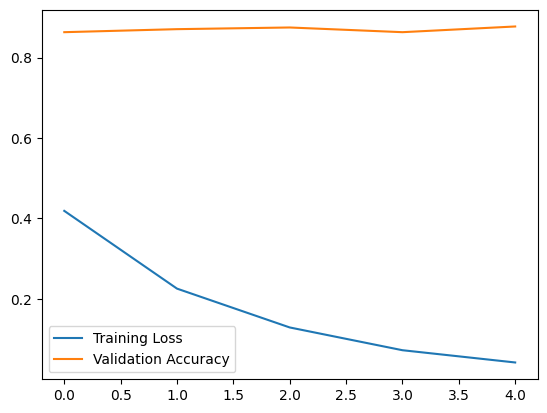

In [37]:
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

for epoch in range(5):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["labels"].cuda()
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")
    train_losses.append(total_loss / len(train_loader))
    
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].cuda()
            attention_mask = batch["attention_mask"].cuda()
            outputs = model(input_ids, attention_mask)
            logits = outputs.detach().cpu().numpy()
            label_ids = batch["labels"].cpu().numpy()
            predictions.extend(torch.argmax(torch.tensor(logits), dim=1).numpy())
    accuracy = accuracy_score(val_labels, predictions)
    print(f"Validation Accuracy: {accuracy:.4f}")
    val_accuracies.append(accuracy)

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(val_labels, predictions)
print("confusion matrix")
print(conf_mat)

In [ ]:
from deep_translator import GoogleTranslator
# Add hardcoded sentences for sentiment predictions
sentences = ["I loved the new movie!", 
             "The food was terrible.", 
             "The hotel room was amazing.",
             "I am feeling sad after reading this book",
             "This sucks",
             "तुमने बहुत बुरा किया",
             "मुझे खाना बहुत पसंद आया"
            ]
def translate_to_english(text):
    translated_text = GoogleTranslator(source='auto', target='en').translate(text)
    return translated_text

for i, text in enumerate(sentences):
    sentences[i] = translate_to_english(text)
# labels = [1, 0, 1]  # 1 for positive sentiment, 0 for negative sentiment

# Convert sentences to required format
encoding = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
input_ids = encoding["input_ids"].cuda()
attention_mask = encoding["attention_mask"].cuda()

# Pass sentences to the model and predict sentiment
outputs = model(input_ids, attention_mask)
logits = outputs.detach().cpu().numpy()
sentiment_predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()

# Print sentiment predictions
for sentence, sentiment in zip(sentences, sentiment_predictions):
    if sentiment == 1:
        print(f"{sentence}: Positive Sentiment")
    else:
        print(f"{sentence}: Negative Sentiment")


In [ ]:
# from joblib import dump
# dump(model, 'BERT1.joblib')

In [ ]:
torch.save(model.state_dict(), "BERT2.pth")

In [ ]:
# import pickle

# # Create an instance of SentimentClassifier
# classifier = SentimentClassifier()

# # Dump the object to a file
# with open('sentiment_classifier.pkl', 'wb') as f:
#     pickle.dump(classifier, f)